# iperf3によるVM間の転送性能テスト

## Kubernets POD 編

### テスト用K8s nodeの稼働状態

In [53]:
!kubectl get nodes -o wide --show-labels

NAME                                   STATUS   ROLES    AGE   VERSION   INTERNAL-IP   EXTERNAL-IP   OS-IMAGE             KERNEL-VERSION      CONTAINER-RUNTIME   LABELS
54574269-7841-4188-8297-7a9e3f9a142a   Ready    <none>   39d   v1.12.4   172.19.16.5   172.19.16.5   Ubuntu 16.04.5 LTS   4.15.0-43-generic   docker://18.6.2     beta.kubernetes.io/arch=amd64,beta.kubernetes.io/os=linux,bosh.id=eeafdc1a-cbc5-4fa7-8713-f3293764d997,bosh.zone=AZ-COMP-1,failure-domain.beta.kubernetes.io/zone=AZ-COMP-1,id=node4,kubernetes.io/hostname=172.19.16.5,spec.ip=172.19.16.5
95bde8c3-7ea5-4f8c-b30a-fb968aefbb2c   Ready    <none>   8d    v1.12.4   172.19.16.7   172.19.16.7   Ubuntu 16.04.5 LTS   4.15.0-43-generic   docker://18.6.2     beta.kubernetes.io/arch=amd64,beta.kubernetes.io/os=linux,bosh.id=977fa6f6-dad4-45cd-96fb-fffd51733a7f,bosh.zone=AZ-COMP-1,failure-domain.beta.kubernetes.io/zone=AZ-COMP-1,id=node3,kubernetes.io/hostname=172.19.16.7,spec.ip=172.19.16.7
a289128f-4d0d-4ab1-ba56-741e5799b1d

### テスト用PODの実行状態

In [54]:
!kubectl get pods -o wide -l app=iperf3 --show-labels --all-namespaces

NAMESPACE   NAME                            READY   STATUS    RESTARTS   AGE   IP            NODE                                   NOMINATED NODE   LABELS
test1       iperf3-dep11-7544f84d6f-nwdt5   1/1     Running   0          25s   172.19.36.2   d90188ac-a570-4766-be89-cffe52a13072   <none>           app=iperf3,pod-template-hash=7544f84d6f
test1       iperf3-dep12-cbd744795-29jnf    1/1     Running   0          25s   172.19.36.3   a289128f-4d0d-4ab1-ba56-741e5799b1df   <none>           app=iperf3,pod-template-hash=cbd744795
test1       iperf3-dep13-6656685677-bbsr5   1/1     Running   0          25s   172.19.36.4   95bde8c3-7ea5-4f8c-b30a-fb968aefbb2c   <none>           app=iperf3,pod-template-hash=6656685677
test1       iperf3-dep14-56d9c4584c-zd45b   1/1     Running   0          25s   172.19.36.5   54574269-7841-4188-8297-7a9e3f9a142a   <none>           app=iperf3,pod-template-hash=56d9c4584c
test2       iperf3-dep21-758ffbd9b8-wjrkx   1/1     Running   0          20s   172.19.37.

### テスト用 pod マニフェストファイルの一つ

In [55]:
! cat ../../deployer/kubernetes/iperf3-4pods-test1.yaml

apiVersion: apps/v1
kind: Deployment
metadata:
  name: iperf3-dep11
  labels:
    app: iperf3
spec:
  replicas: 1
  selector:
    matchLabels:
      app: iperf3
  template:
    metadata:
      labels:
        app: iperf3
    spec:
      hostname: iperf3-dep11
      affinity:
        nodeAffinity:
          preferredDuringSchedulingIgnoredDuringExecution:
          - weight: 1
            preference:
              matchExpressions:
              - key: kubernetes.io/role
                operator: In
                values:
                - master
      tolerations:
        - key: node-role.kubernetes.io/master
          operator: Exists
          effect: NoSchedule
      containers:
      - name: iperf3
        image: networkstatic/iperf3
        command: ['/bin/sh', '-c', 'sleep infinity']
        # To benchmark manually: kubectl exec iperf3-clients-jlfxq -- /bin/sh -c 'iperf3 -c iperf3-server'
        ports:
        - containerPort: 5201
          protocol: TCP
          name: iperf3

### テストスクリプトのオプション

In [56]:
%run -i k8s_iperf3_peer_p3.py -h

usage: k8s_iperf3_peer_p3.py [-h] -C CONFIGFILE -N TESTNAME [-i INTERVAL]
                             [-b BANDWIDTH] [-M MSS] [-P PARALLEL] [-t TIME]
                             [-u] [--getserveroutput] [--getesxtop]

Standard Arguments for iperf3 testing

optional arguments:
  -h, --help            show this help message and exit
  -C CONFIGFILE, --configfile CONFIGFILE
                        config file for iperf3 test
  -N TESTNAME, --testname TESTNAME
                        name for the iperf3 test, not to be unique
  -i INTERVAL, --interval INTERVAL
                        second for periodic bandwidth report, defaulty no
                        report
  -b BANDWIDTH, --bandwidth BANDWIDTH
                        target bandwidth in bps, default 1 Mbit/sec for UDP,
                        unlimited for TCP
  -M MSS, --mss MSS     TCP maximum segmnet size (MTU - 40), default 1460
                        bytes
  -P PARALLEL, --parallel PARALLEL
                        number of 

### 同一の k8s namespace 内の4つのPOD間でUDPスループットを計測(60秒, 100Mbps/flow)

[Test parameters per Peers]
| Protocol: UDP | Bandwidth(bps): 100M | MSS(byte): 1460 | Streams: 1 | Interval(s): 1 | Time(s): 60 | Use Client side data
Testing, wait 60 seconds...  done
[Test Result]
| Number of peers: 2
[Test Result]
| Number of hosts: 0

/home/vmware/advlabtools/tester/jupyter/reports/k8s-2peers-iperf3-190403-135409/k8s-2peers-cl-iperf3-dep14-56d9c4584c-zd45b.json
| Avg Bandwidth(Gbps): 0.0998525 | Jitter(ms): 0.123143 | Lost Packets: 2276 | Lost %: 2.48966
| Sender CPU%: 9.35653 | Receiver CPU%: 3.14802
/home/vmware/advlabtools/tester/jupyter/reports/k8s-2peers-iperf3-190403-135409/k8s-2peers-cl-iperf3-dep13-6656685677-bbsr5.json
| Avg Bandwidth(Gbps): 0.0998448 | Jitter(ms): 0.0370357 | Lost Packets: 5920 | Lost %: 6.47624
| Sender CPU%: 8.87929 | Receiver CPU%: 3.04889


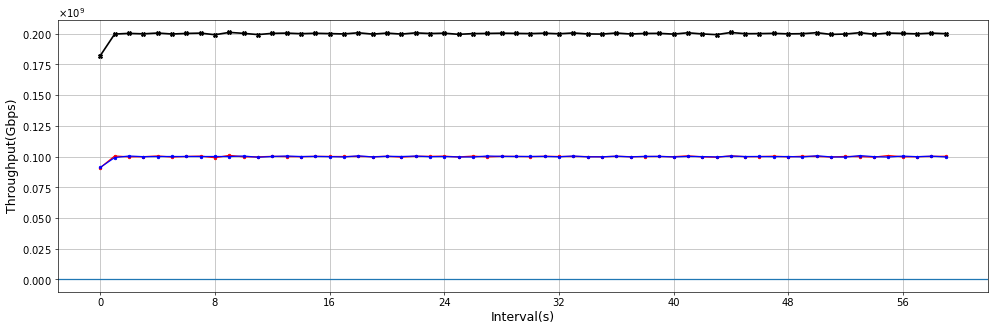

In [57]:
%run -i k8s_iperf3_peer_p3.py -C k8s-2peers-1ns-config.yaml -N k8s-2peers -t 60 -b 100M -u

### 異なる k8s namespace 内の4つのPOD間でUDPスループットを計測(60秒, 100Mbps/flow)

[Test parameters per Peers]
| Protocol: UDP | Bandwidth(bps): 100M | MSS(byte): 1460 | Streams: 1 | Interval(s): 1 | Time(s): 60 | Use Client side data
Testing, wait 60 seconds...  done
[Test Result]
| Number of peers: 2
[Test Result]
| Number of hosts: 0

/home/vmware/advlabtools/tester/jupyter/reports/k8s-2peers-iperf3-190403-140525/k8s-2peers-cl-iperf3-dep23-79c6f45c56-vg9xs.json
| Avg Bandwidth(Gbps): 0.0998502 | Jitter(ms): 0.0960277 | Lost Packets: 3084 | Lost %: 3.37359
| Sender CPU%: 8.81458 | Receiver CPU%: 3.51158
/home/vmware/advlabtools/tester/jupyter/reports/k8s-2peers-iperf3-190403-140525/k8s-2peers-cl-iperf3-dep24-7bf46dd5d-v6b6m.json
| Avg Bandwidth(Gbps): 0.0998491 | Jitter(ms): 0.247617 | Lost Packets: 5433 | Lost %: 5.94967
| Sender CPU%: 8.49414 | Receiver CPU%: 2.9866


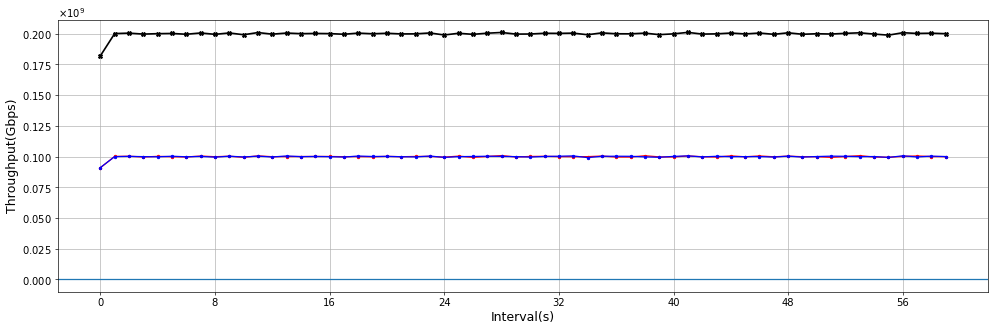

In [62]:
%run -i k8s_iperf3_peer_p3.py -C k8s-2peers-2ns-config.yaml -N k8s-2peers -t 60 -b 100M -u

### 同一の k8s namespace 内の4つのPOD間でTCPスループットを計測(60秒, 1Gbps/flow)

[Test parameters per Peers]
| Protocol: TCP | Bandwidth(bps): 1G | MSS(byte): 1460 | Streams: 1 | Interval(s): 1 | Time(s): 60 | Use Client side data
Testing, wait 60 seconds...  done
[Test Result]
| Number of peers: 2
[Test Result]
| Number of hosts: 0

/home/vmware/advlabtools/tester/jupyter/reports/k8s-2peers-iperf3-190403-135538/k8s-2peers-cl-iperf3-dep14-56d9c4584c-zd45b.json
| Avg Bandwidth(Gbps): 0.998968 | Retransmits: 5707
| Sender CPU%: 7.29639 | Receiver CPU%: 11.4274
/home/vmware/advlabtools/tester/jupyter/reports/k8s-2peers-iperf3-190403-135538/k8s-2peers-cl-iperf3-dep13-6656685677-bbsr5.json
| Avg Bandwidth(Gbps): 0.998982 | Retransmits: 6535
| Sender CPU%: 7.13164 | Receiver CPU%: 11.1233


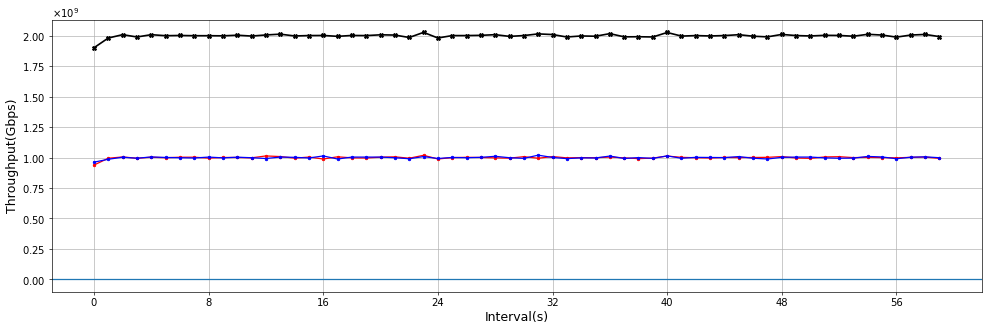

In [58]:
%run -i k8s_iperf3_peer_p3.py -C k8s-2peers-1ns-config.yaml -N k8s-2peers -t 60 -b 1G

### 異なるK8s namespace 内の4つのPOD間でTCPスループットを計測(60秒, 1Gbps)

[Test parameters per Peers]
| Protocol: TCP | Bandwidth(bps): 1G | MSS(byte): 1460 | Streams: 1 | Interval(s): 1 | Time(s): 60 | Use Client side data
Testing, wait 60 seconds...  done
[Test Result]
| Number of peers: 2
[Test Result]
| Number of hosts: 0

/home/vmware/advlabtools/tester/jupyter/reports/k8s-2peers-ip-iperf3-190403-135926/k8s-2peers-ip-cl-iperf3-dep23-79c6f45c56-vg9xs.json
| Avg Bandwidth(Gbps): 0.999266 | Retransmits: 5232
| Sender CPU%: 7.1417 | Receiver CPU%: 11.2083
/home/vmware/advlabtools/tester/jupyter/reports/k8s-2peers-ip-iperf3-190403-135926/k8s-2peers-ip-cl-iperf3-dep24-7bf46dd5d-v6b6m.json
| Avg Bandwidth(Gbps): 0.999051 | Retransmits: 3823
| Sender CPU%: 7.39758 | Receiver CPU%: 11.5813


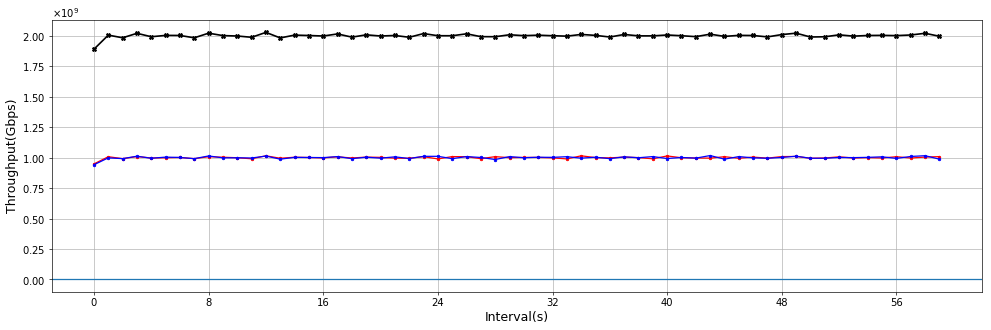

In [60]:
%run -i k8s_iperf3_peer_p3.py -C k8s-2peers-2ns-config.yaml -N k8s-2peers-ip -t 60 -b 1G

### 同一のK8s namespace 内の4つのPOD間でTCPスループットを計測(60秒, 無制限)

[Test parameters per Peers]
| Protocol: TCP | Unlimitted Bandwidth | MSS(byte): 1460 | Streams: 1 | Interval(s): 1 | Time(s): 60 | Use Client side data
Testing, wait 60 seconds...  done
[Test Result]
| Number of peers: 2
[Test Result]
| Number of hosts: 0

/home/vmware/advlabtools/tester/jupyter/reports/k8s-2peers-iperf3-190404-153419/k8s-2peers-cl-iperf3-dep14-56d9c4584c-zd45b.json
| Avg Bandwidth(Gbps): 2.57206 | Retransmits: 9491
| Sender CPU%: 10.3974 | Receiver CPU%: 16.1092
/home/vmware/advlabtools/tester/jupyter/reports/k8s-2peers-iperf3-190404-153419/k8s-2peers-cl-iperf3-dep13-6656685677-bbsr5.json
| Avg Bandwidth(Gbps): 1.94622 | Retransmits: 6818
| Sender CPU%: 8.66134 | Receiver CPU%: 15.5807


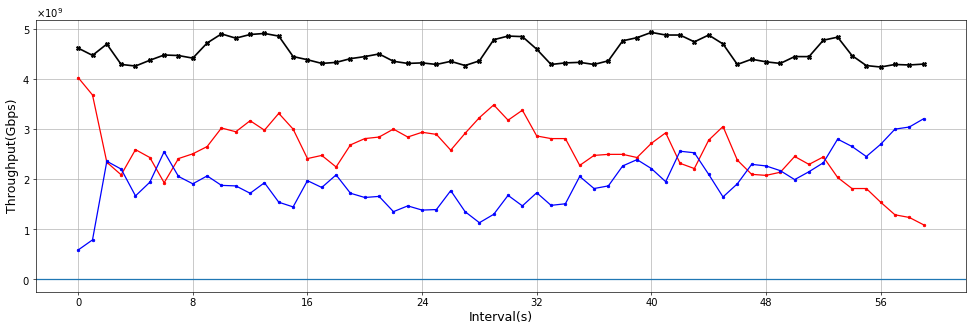

In [63]:
%run -i k8s_iperf3_peer_p3.py -C k8s-2peers-1ns-config.yaml -N k8s-2peers -t 60

### 異なるK8s namespace 内の4つのPOD間でTCPスループットを計測(60秒, 無制限)

[Test parameters per Peers]
| Protocol: TCP | Unlimitted Bandwidth | MSS(byte): 1460 | Streams: 1 | Interval(s): 1 | Time(s): 60 | Use Client side data
Testing, wait 60 seconds...  done
[Test Result]
| Number of peers: 2
[Test Result]
| Number of hosts: 0

/home/vmware/advlabtools/tester/jupyter/reports/k8s-2peers-ip-iperf3-190403-140058/k8s-2peers-ip-cl-iperf3-dep23-79c6f45c56-vg9xs.json
| Avg Bandwidth(Gbps): 2.2036 | Retransmits: 11553
| Sender CPU%: 9.17912 | Receiver CPU%: 16.0758
/home/vmware/advlabtools/tester/jupyter/reports/k8s-2peers-ip-iperf3-190403-140058/k8s-2peers-ip-cl-iperf3-dep24-7bf46dd5d-v6b6m.json
| Avg Bandwidth(Gbps): 2.31231 | Retransmits: 10191
| Sender CPU%: 9.68455 | Receiver CPU%: 16.9721


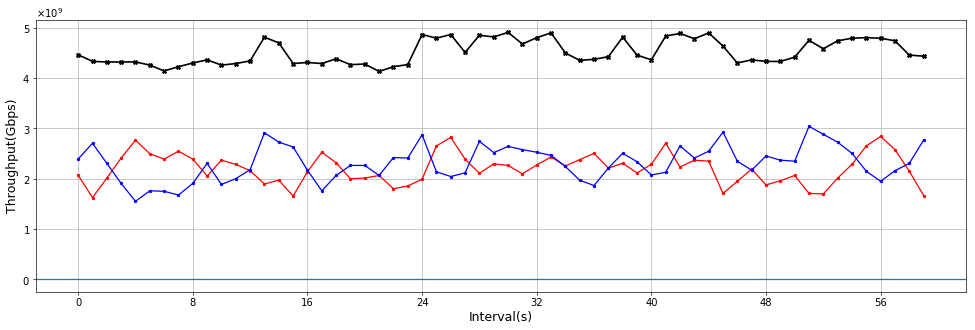

In [61]:
%run -i k8s_iperf3_peer_p3.py -C k8s-2peers-2ns-config.yaml -N k8s-2peers-ip -t 60

### テスト用Pythonスクリプトを直接編集してテストをカスタマイズ

Testing, wait 10 seconds...  done
/root/mytesttools/tester/jupyter/reports/mytest01-iperf3-180328-194704/mytest01-cl-172.16.130.202.json


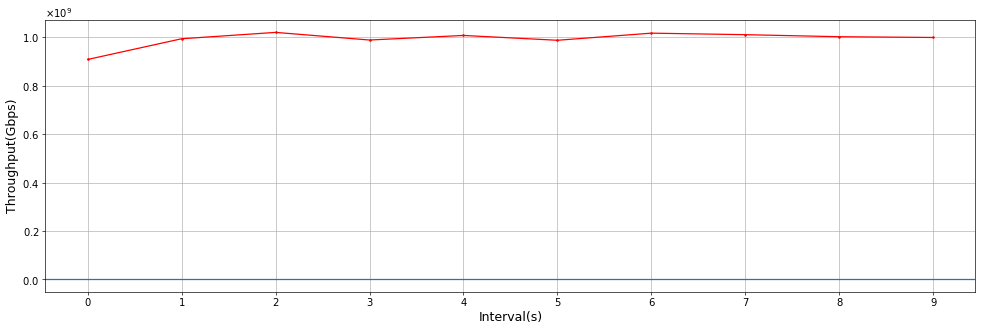

/root/mytesttools/tester/jupyter/reports/mytest01-iperf3-180328-194704/mytest01-cl-172.16.130.201.json


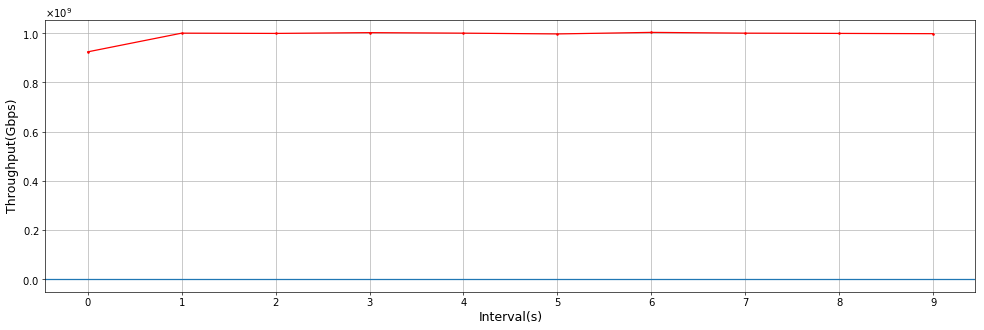

/root/mytesttools/tester/jupyter/reports/mytest01-iperf3-180328-194704/mytest01-cl-172.16.130.204.json


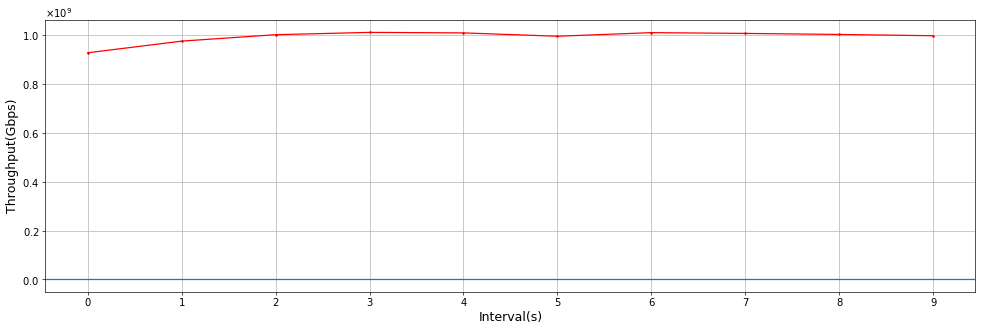

/root/mytesttools/tester/jupyter/reports/mytest01-iperf3-180328-194704/mytest01-cl-172.16.130.203.json


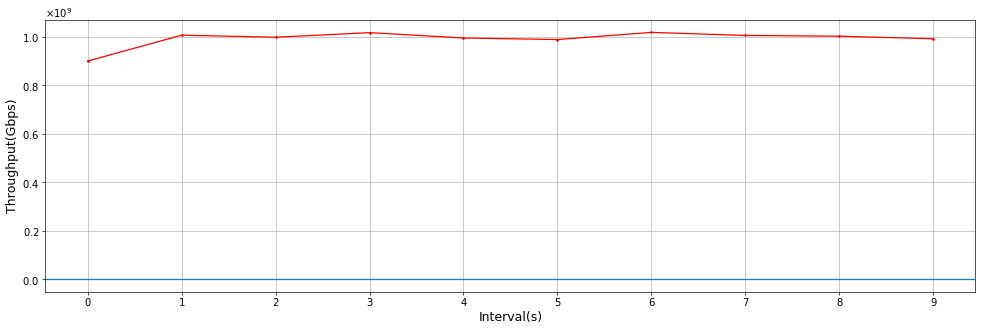

In [27]:
#! /usr/bin/env python
# -*- coding: utf-8 -*-

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import os
import subprocess
import json
import glob

class FixedOrderFormatter(ticker.ScalarFormatter):
    def __init__(self, order_of_mag=0, useOffset=True, useMathText=True):
        self._order_of_mag = order_of_mag
        ticker.ScalarFormatter.__init__(self, useOffset=useOffset,
                                 useMathText=useMathText)
    def _set_orderOfMagnitude(self, range):
        self.orderOfMagnitude = self._order_of_mag

ConfigFile='DLS4-config'
TestName='mytest01'
Interval='1'
Bandwidth='1G'
Time='10'
Udp=False

def set_option():
    options = " -C " + ConfigFile + " -N " + TestName + " -J -s "
    if Interval:
        options = options + " -i " + Interval
    if Bandwidth:
        options = options + " -b " + Bandwidth
    if Time:
        options = options + " -t " + Time
    if Udp:
        options = options + " -u "

    return options

def init_plt():
    plt.figure(num=None, figsize=(20, 6), dpi=60, facecolor='w', edgecolor='k')
    plt.rcParams["font.size"] = 15
    plt.rcParams["xtick.labelsize"] = 12
    plt.rcParams["ytick.labelsize"] = 12
    plt.rcParams["legend.fontsize"] = 12
    plt.grid()
    plt.axhline(y=0)
    plt.xlabel("Interval(s)")
    plt.ylabel(u"Throughput(Gbps)")
    plt.gca().yaxis.set_major_formatter(FixedOrderFormatter(9, useOffset=False))
    plt.gca().get_xaxis().set_major_locator(ticker.MaxNLocator(integer=True))

def main():
    cmd = "../scripts/run_iperf3_peer.bash "
    cmd_options = set_option()

    print 'Testing, wait {} seconds... '.format(Time),
    dirname = str(subprocess.check_output( cmd+cmd_options, shell=True, universal_newlines=True )).replace('\n','')
    print 'done'

    json_files = glob.glob(dirname + "/*cl*.json")

    for file in json_files:
        print(file)
        f = open(file, 'r')
        perf_dict = json.load(f)

        init_plt()

        x = np.array(range(len(perf_dict["intervals"])))
        y = np.array([])

        for p in perf_dict["intervals"]:
            y = np.append(y, p["sum"]["bits_per_second"])

        plt.plot(x, y, "r",marker="o",markersize=2)

        plt.show()

# Start program
if __name__ == "__main__":
    main()